### Load Packages

In [1]:
'''Import basic modules.'''
import pandas as pd
import numpy as np


'''Customize visualization
Seaborn and matplotlib visualization.'''
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import folium 
from IPython.core.display import HTML
import urllib.request
from PIL import Image
from wordcloud import WordCloud ,STOPWORDS


'''Plotly visualization .'''
import plotly.express as px
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
py.init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [3]:
complete = pd.read_csv('/kaggle/input/corona-virus-report/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
complete.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.15330,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.03390,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.50630,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.20270,17.873900,2020-01-22,0,0,0,0,Africa


### Russia Sample data

In [4]:
russia = complete[complete['Country/Region'] == 'Russia']
display(russia.head(3))
display(russia.tail(3))
display(russia.shape)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
185,NaN,Russia,61.52401,105.318756,2020-01-22,0,0,0,0,Europe
446,NaN,Russia,61.52401,105.318756,2020-01-23,0,0,0,0,Europe
707,NaN,Russia,61.52401,105.318756,2020-01-24,0,0,0,0,Europe


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
48470,NaN,Russia,61.52401,105.318756,2020-07-25,805332,13172,596064,196096,Europe
48731,NaN,Russia,61.52401,105.318756,2020-07-26,811073,13249,599172,198652,Europe
48992,NaN,Russia,61.52401,105.318756,2020-07-27,816680,13334,602249,201097,Europe


(188, 10)

## Missing Data Analysis

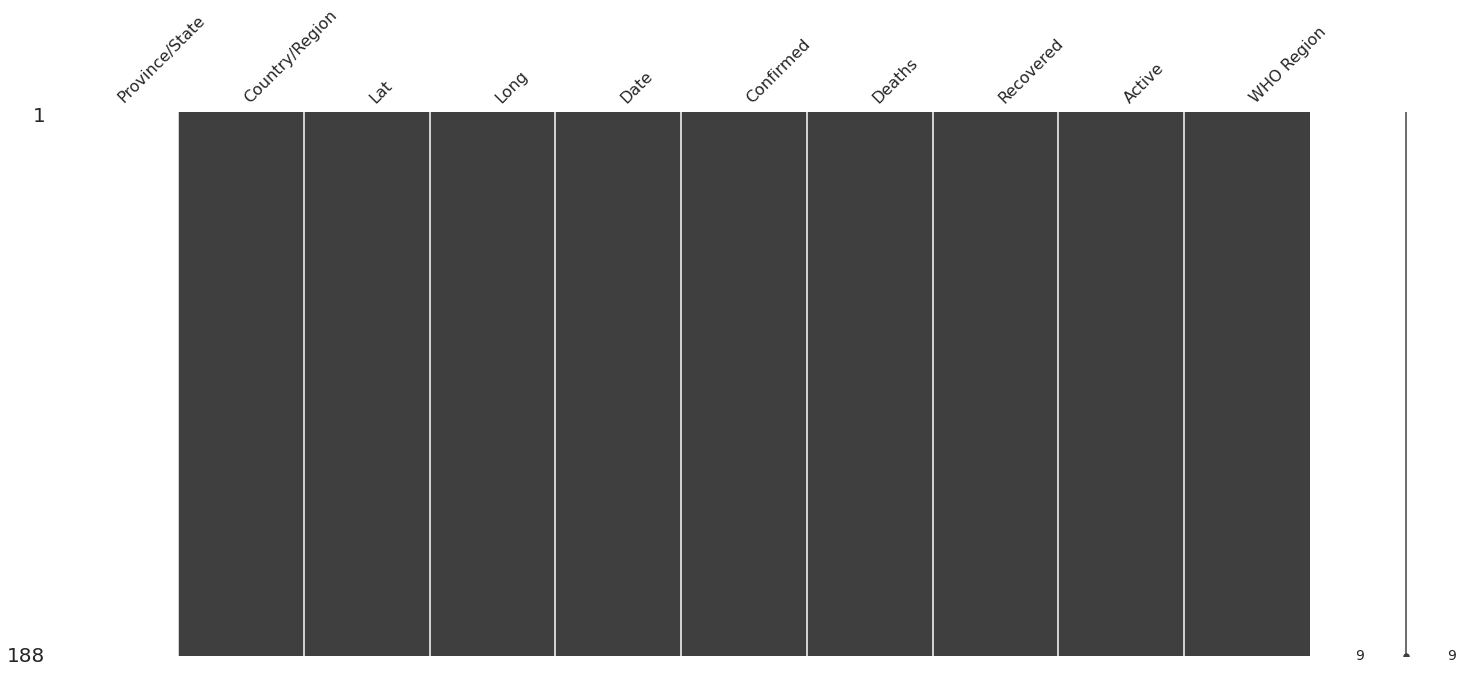

In [15]:
import missingno as msno
msno.matrix(russia)
plt.show()

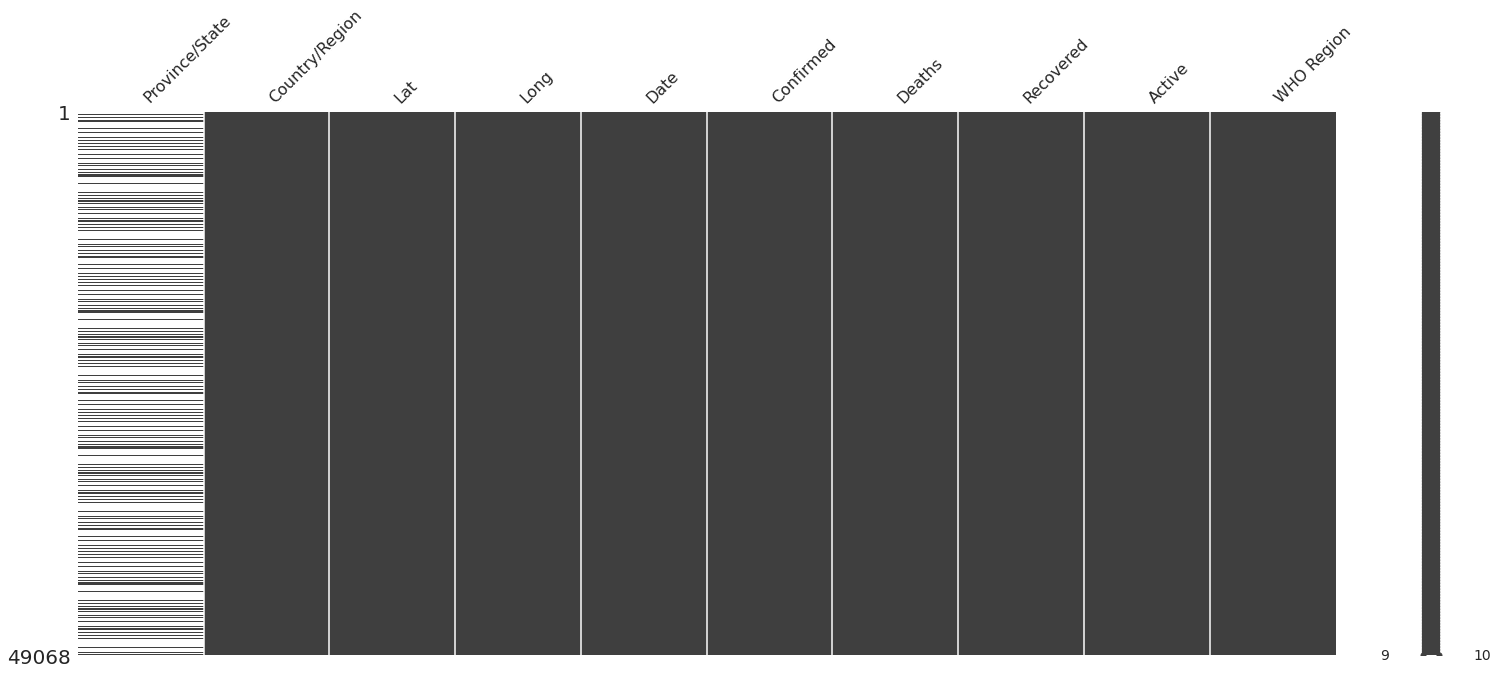

In [17]:
msno.matrix(complete)
plt.show()

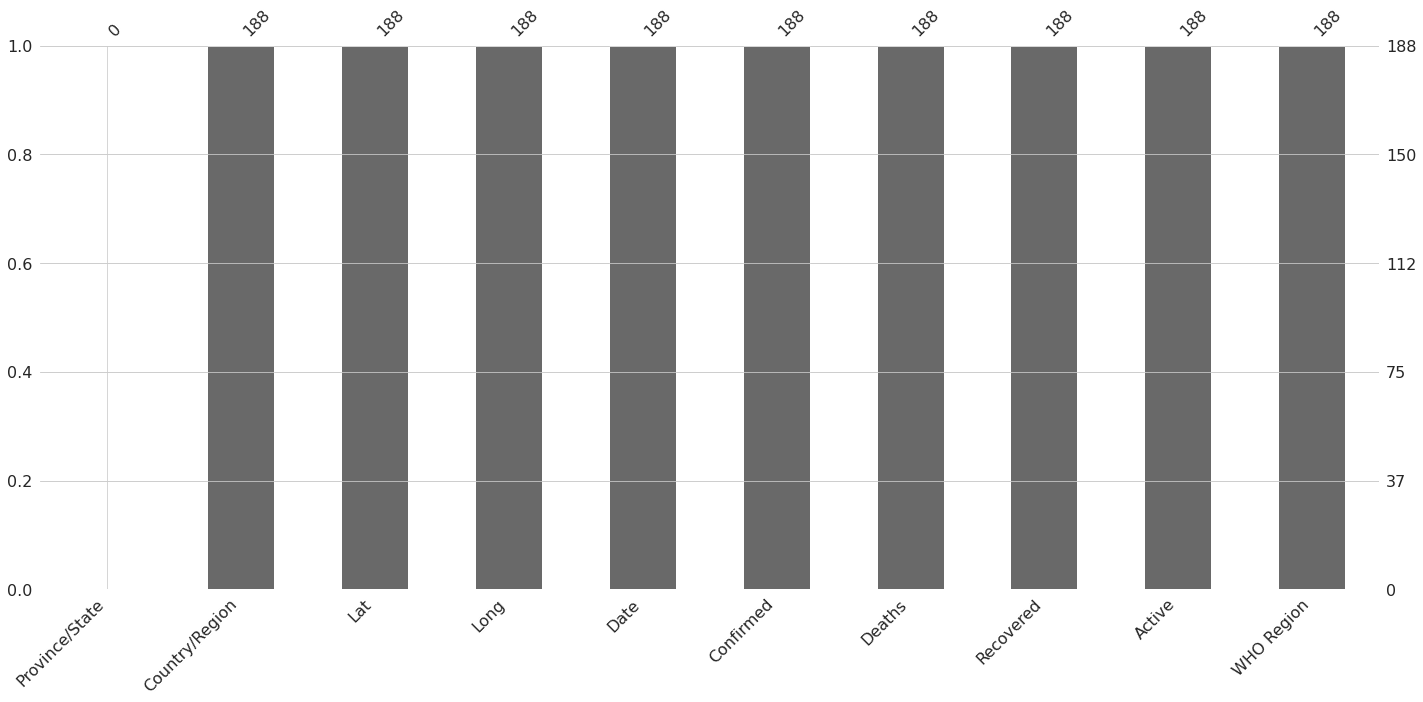

In [18]:
msno.bar(russia)
plt.show()

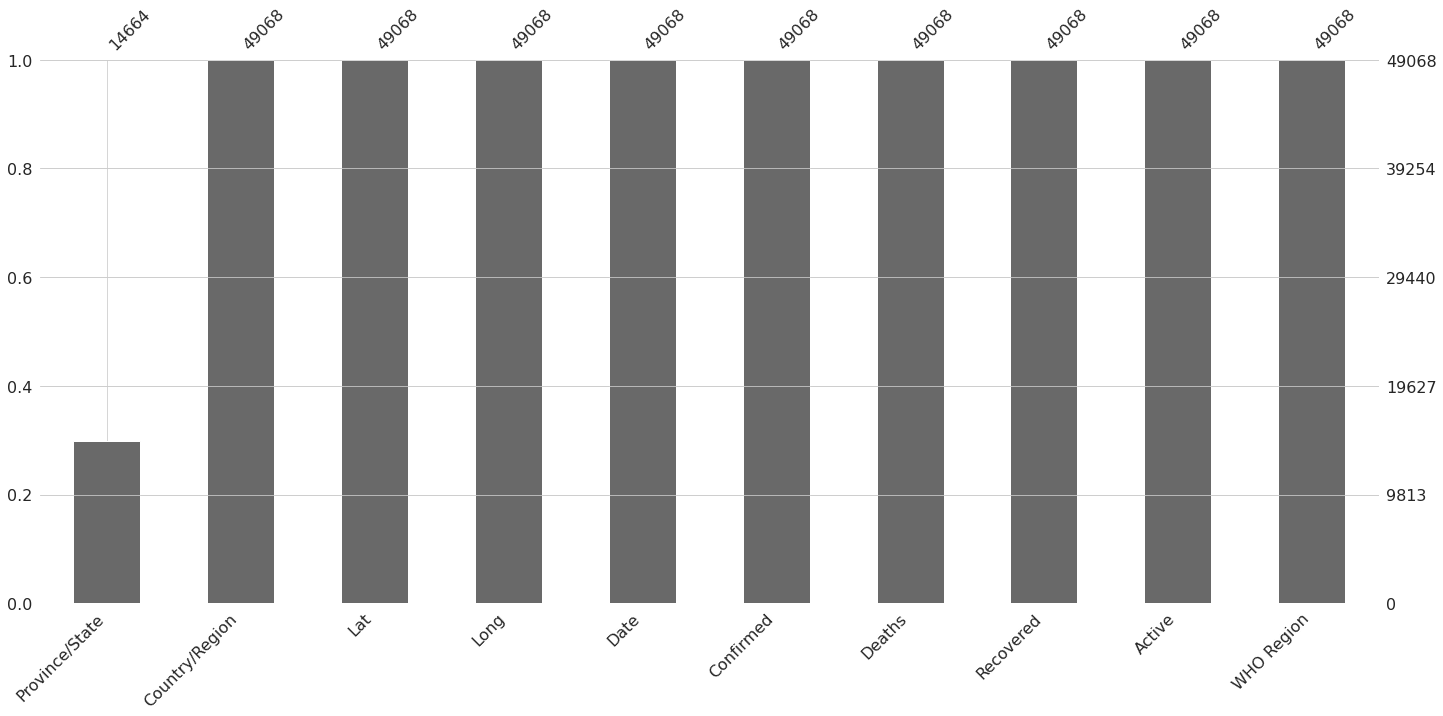

In [19]:
msno.bar(complete)
plt.show()

### Define the dataset

In [20]:
# Defining COVID-19 cases as per classifications 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Defining Active Case: Active Case = confirmed - deaths - recovered
complete['Active'] = complete['Confirmed'] - complete['Deaths'] - complete['Recovered']

# latest
full_latest = complete[complete['Date'] == max(complete['Date'])].reset_index()

# latest condensed
full_latest_grouped = full_latest.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

temp = complete.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp.head(10)

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-22,555,17,28,510
1,2020-01-23,654,18,30,606
2,2020-01-24,941,26,36,879
3,2020-01-25,1434,42,39,1353
4,2020-01-26,2118,56,52,2010
5,2020-01-27,2927,82,61,2784
6,2020-01-28,5578,131,107,5340
7,2020-01-29,6166,133,125,5908
8,2020-01-30,8234,171,141,7922
9,2020-01-31,9927,213,219,9495


### Latest Record

In [21]:
confirmed = full_latest_grouped.sum().Confirmed
deaths =  full_latest_grouped.sum().Deaths
recovered =  full_latest_grouped.sum().Recovered
active =  full_latest_grouped.sum().Active
row = [temp.iloc[-1,].Date,confirmed,deaths,recovered,active]
latest = pd.DataFrame([row], columns = full_latest_grouped.columns)
latest.style.background_gradient(cmap='Blues')

,Country/Region,Confirmed,Deaths,Recovered,Active
0,2020-07-27 00:00:00,16480485,654036,9468087,6358362


### Top 5 Most Confirmed Cases

In [22]:
temp_f = full_latest_grouped.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)
temp_f = temp_f.iloc[:50]
temp_f.head().style.background_gradient(cmap='Blues')

,Country/Region,Confirmed,Deaths,Recovered,Active
0,US,4290259,148011,1325804,2816444
1,Brazil,2442375,87618,1846641,508116
2,India,1480073,33408,951166,495499
3,Russia,816680,13334,602249,201097
4,South Africa,452529,7067,274925,170537


### Top 50 Confirmed Cases (Max and Min)

In [23]:
print('The most cases are confirmed:',temp_f.Confirmed.max())
print('The fewest cases are confirmed:',temp_f.Confirmed.min())

The most cases are confirmed: 4290259
The fewest cases are confirmed: 37390


### Ratios Deaths and Recovered

In [24]:
ratio_r = list()
ratio_d = list()
for i in range(len(temp_f)):
    ratio_r.append(temp_f.iloc[i,3]/temp_f.iloc[i,1])
    ratio_d.append(temp_f.iloc[i,2]/temp_f.iloc[i,1])
temp_f['Ratio_Recovered'] = ratio_r
temp_f['Ratio_Deaths'] = ratio_d

temp_ff = temp_f.sort_values(by='Ratio_Deaths', ascending=False)
temp_bb = temp_f.sort_values(by='Ratio_Recovered', ascending=False)
display(temp_ff.iloc[:10,].style.background_gradient(cmap='Blues'))
display(temp_bb.iloc[:10,].style.background_gradient(cmap='Blues'))


,Country/Region,Confirmed,Deaths,Recovered,Active,Ratio_Recovered,Ratio_Deaths
8,United Kingdom,301708,45844,1437,254427,0.004763,0.151948
34,Belgium,66428,9822,17452,39154,0.262721,0.147859
14,Italy,246286,35112,198593,12581,0.806351,0.142566
17,France,220352,30212,81212,108928,0.368556,0.137108
40,Netherlands,53413,6160,189,47064,0.003538,0.115328
5,Mexico,395489,44022,303810,47657,0.768188,0.111310
11,Spain,272421,28432,150376,93613,0.551999,0.104368
20,Canada,116458,8944,0,107514,0.000000,0.076800
29,Sweden,79395,5700,0,73695,0.000000,0.071793
28,Ecuador,81161,5532,34896,40733,0.429960,0.068161


,Country/Region,Confirmed,Deaths,Recovered,Active,Ratio_Recovered,Ratio_Deaths
22,Qatar,109597,165,106328,3104,0.970173,0.001506
15,Turkey,227019,5630,210469,10920,0.927099,0.024800
7,Chile,347923,9187,319954,18782,0.919612,0.026405
18,Germany,207112,9125,190314,7673,0.918894,0.044058
48,Bahrain,39482,141,36110,3231,0.914594,0.003571
25,China,86783,4656,78869,3258,0.908807,0.053651
32,Belarus,67251,538,60492,6221,0.899496,0.008000
41,Singapore,50838,27,45692,5119,0.898777,0.000531
39,United Arab Emirates,59177,345,52510,6322,0.887338,0.005830
10,Pakistan,274289,5842,241026,27421,0.878730,0.021299


In [25]:
fig = px.bar(temp_f.sort_values('Ratio_Deaths', ascending=False).head(15), 
             y="Ratio_Deaths", x="Country/Region", color= "Country/Region",
             title='Top 15 Ratio_Deaths', 
             orientation='v',
             color_discrete_sequence = px.colors.cyclical.IceFire,
             width=700, height=600)
fig.update_traces(opacity=0.8)

fig.update_layout(template = 'plotly_white')
fig.show()

In [26]:
fig = px.bar(temp_f.sort_values('Ratio_Recovered', ascending=False).head(15), 
             y="Ratio_Recovered", x="Country/Region", color= "Country/Region",
             title='Top 15 Ratio_Recovered', 
             orientation='v',
             color_discrete_sequence = px.colors.cyclical.IceFire,
             width=700, height=600)
fig.update_traces(opacity=0.8)

fig.update_layout(template = 'plotly_white')
fig.show()

### Best Ratio

In [28]:
temp_f['Best_Ratio'] = temp_f['Ratio_Recovered'] - temp_f['Ratio_Deaths']

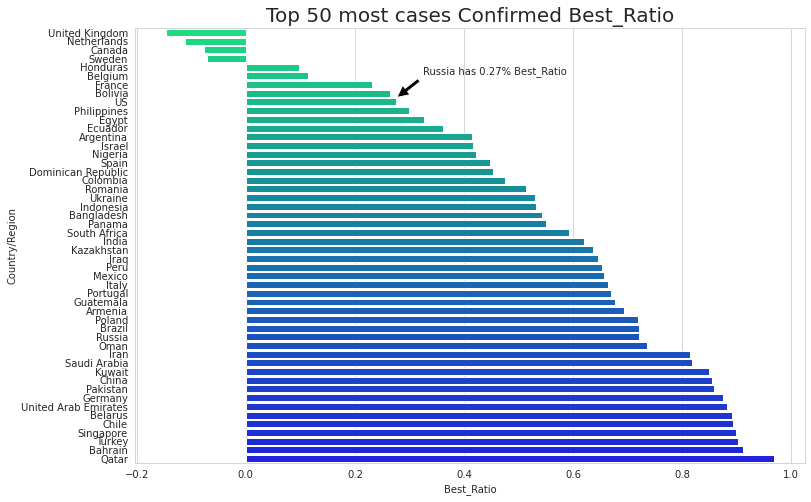

In [32]:
fig,axes = plt.subplots(1,1, figsize=(12,8))

sns.barplot(x='Best_Ratio', y='Country/Region', data=temp_f.sort_values(by='Best_Ratio'), palette='winter_r',ax=axes)
for i,p in enumerate(axes.patches):
    if i == 8:
        height = p.get_height()
        axes.annotate('Russia has {:.2f}% Best_Ratio '.format(p.get_width()),xy = (p.get_width(),p.get_xy()[1]),xytext = (p.get_x()+ p.get_width()+0.05, height+4),
                      arrowprops = dict(facecolor='black',shrink=0.05))
        
        
plt.title('Top 50 most cases Confirmed Best_Ratio', fontsize=20)
plt.show()

## Temperature
This dataset I collected from [Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) using beautiful soup. If you want to see my notebook, you can check [here](https://www.kaggle.com/efradgamer/temperature-scrapping-from-wikipedia-2020).

In [34]:
world_temp_2020 = pd.read_csv('/kaggle/input/world-average-temperature/Avg_World_Temp_2020.csv')
Continent = world_temp_2020.Continent

world_temp_2020 = world_temp_2020.iloc[:,:-9].drop('Unnamed: 0', axis=1)
world_temp_2020.drop('City',axis=1,inplace=True)

world_temp_2020['Avg_temp'] = world_temp_2020.groupby('Country').transform(lambda x: x.mean()).mean(axis=1)
world_temp_2020['Continent'] = Continent

Country = full_latest_grouped[full_latest_grouped['Country/Region'].isin(world_temp_2020['Country'])]
Country['Country'] = Country['Country/Region']

full = pd.merge(Country, world_temp_2020, on='Country', how='left')
full.drop(columns = ['Country/Region','Jan','Feb','Mar','Apr','May'],inplace=True)

In [35]:
display(world_temp_2020.head())
display(full.head())

,Country,Jan,Feb,Mar,Apr,May,Avg_temp,Continent
0,Algeria,11.2,11.9,12.8,14.7,17.7,18.660000,Africa
1,Algeria,12.8,15.0,18.1,22.2,26.1,18.660000,Africa
2,Algeria,16.0,18.2,23.1,27.9,32.2,18.660000,Africa
3,Angola,26.7,28.5,28.6,28.2,27.0,27.800000,Africa
4,Benin,27.3,28.5,28.9,28.6,27.8,28.566667,Africa


,Confirmed,Deaths,Recovered,Active,Country,Avg_temp,Continent
0,36263,1269,25198,9796,Afghanistan,6.68,Asia
1,4880,144,2745,1991,Albania,11.18,Europe
2,27973,1163,18837,7973,Algeria,18.66,Africa
3,27973,1163,18837,7973,Algeria,18.66,Africa
4,27973,1163,18837,7973,Algeria,18.66,Africa


In [36]:
africa_temp = full[full['Continent'] == 'Africa']
asia_temp = full[full['Continent'] == 'Asia']
europe_temp = full[full['Continent'] == 'Europe']
na_temp = full[full['Continent'] == 'North America']
ocenia_temp = full[full['Continent'] == 'Oceania']
sa_temp = full[full['Continent'] == 'South America']

## Asia

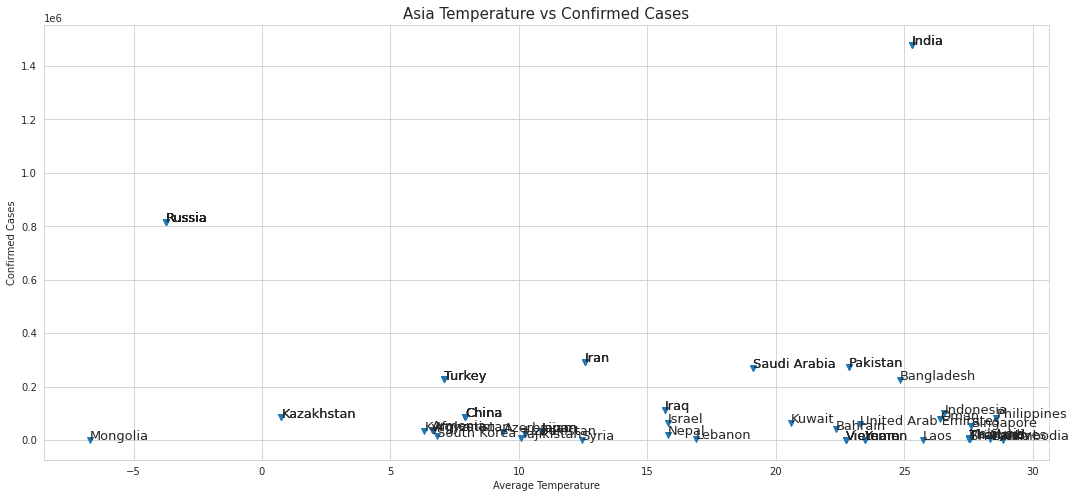

In [37]:
fig, ax = plt.subplots(figsize = (18,8))
ax.scatter(asia_temp['Avg_temp'], asia_temp['Confirmed'], marker='v')
plt.xlabel('Average Temperature')
plt.ylabel('Confirmed Cases')
plt.title('Asia Temperature vs Confirmed Cases', fontsize=15)
for i, txt in zip(asia_temp.index,asia_temp.Country):
    ax.annotate(txt, (asia_temp['Avg_temp'][i], asia_temp['Confirmed'][i]),fontsize=13)

## Africa

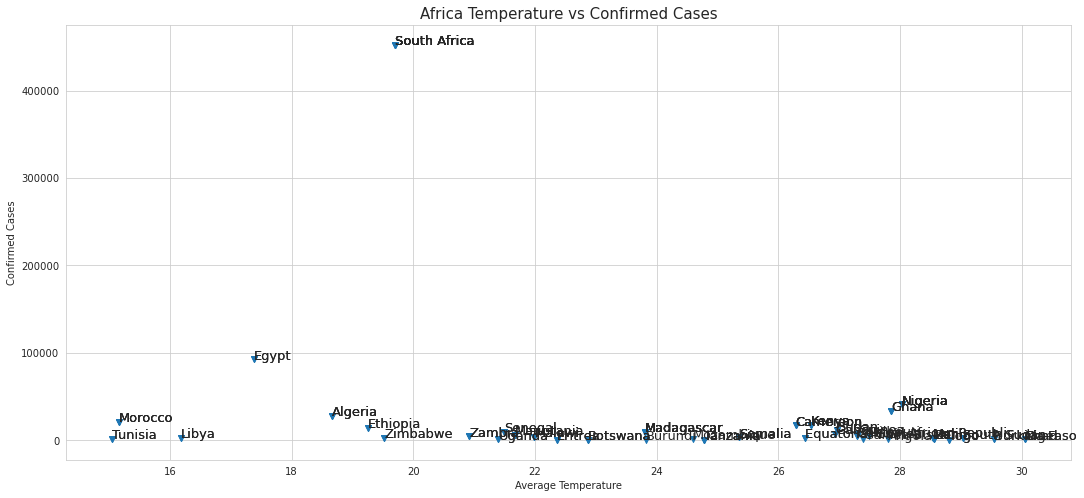

In [38]:
fig, ax = plt.subplots(figsize = (18,8))
ax.scatter(africa_temp['Avg_temp'], africa_temp['Confirmed'], marker='v')
plt.xlabel('Average Temperature')
plt.ylabel('Confirmed Cases')
plt.title('Africa Temperature vs Confirmed Cases', fontsize=15)
for i, txt in zip(africa_temp.index,africa_temp.Country):
    ax.annotate(txt, (africa_temp['Avg_temp'][i], africa_temp['Confirmed'][i]),fontsize=13)

## Europe

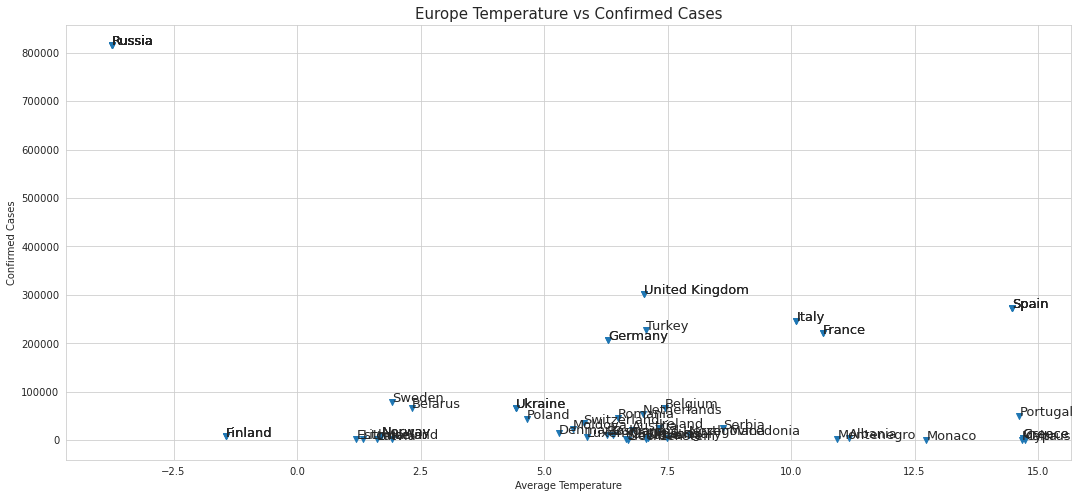

In [39]:
fig, ax = plt.subplots(figsize = (18,8))
ax.scatter(europe_temp['Avg_temp'], europe_temp['Confirmed'], marker='v')
plt.xlabel('Average Temperature')
plt.ylabel('Confirmed Cases')
plt.title('Europe Temperature vs Confirmed Cases', fontsize=15)
for i, txt in zip(europe_temp.index,europe_temp.Country):
    ax.annotate(txt, (europe_temp['Avg_temp'][i], europe_temp['Confirmed'][i]),fontsize=13)

## North America

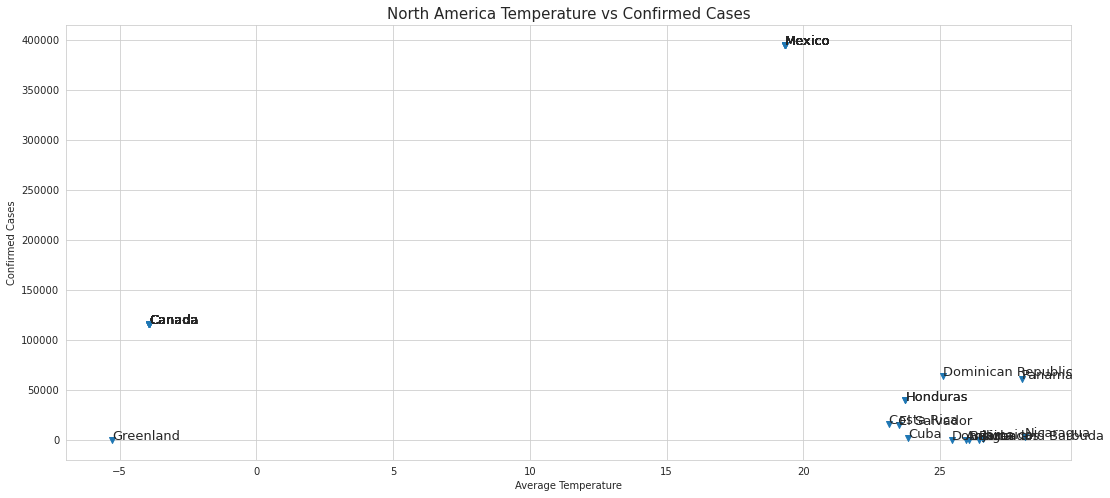

In [40]:
fig, ax = plt.subplots(figsize = (18,8))
ax.scatter(na_temp['Avg_temp'], na_temp['Confirmed'], marker='v')
plt.xlabel('Average Temperature')
plt.ylabel('Confirmed Cases')
plt.title('North America Temperature vs Confirmed Cases', fontsize=15)
for i, txt in zip(na_temp.index,na_temp.Country):
    ax.annotate(txt, (na_temp['Avg_temp'][i], na_temp['Confirmed'][i]),fontsize=13)

## Oceania

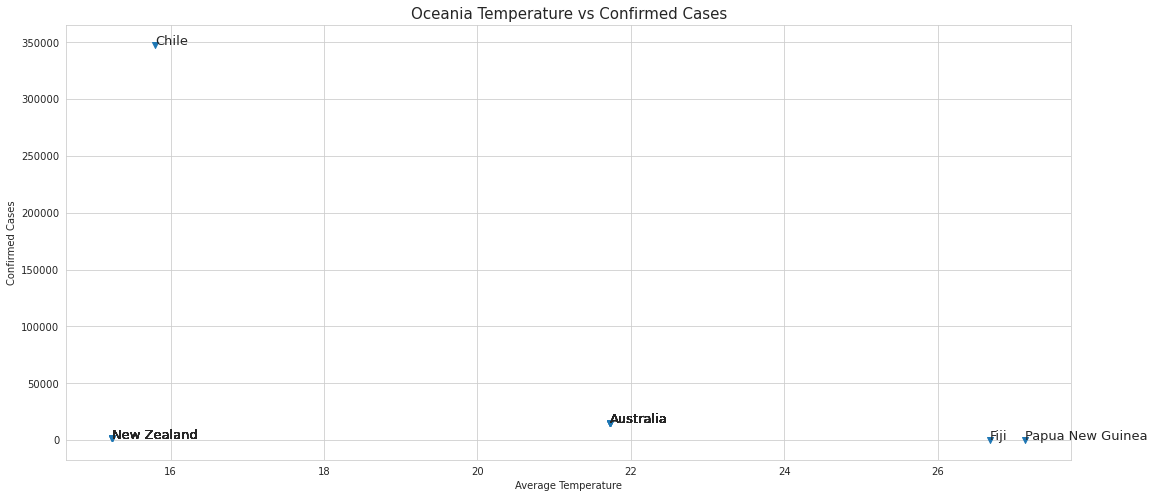

In [42]:
fig, ax = plt.subplots(figsize = (18,8))
ax.scatter(ocenia_temp['Avg_temp'], ocenia_temp['Confirmed'], marker='v')
plt.xlabel('Average Temperature')
plt.ylabel('Confirmed Cases')
plt.title('Oceania Temperature vs Confirmed Cases', fontsize=15)
for i, txt in zip(ocenia_temp.index,ocenia_temp.Country):
    ax.annotate(txt, (ocenia_temp['Avg_temp'][i], ocenia_temp['Confirmed'][i]),fontsize=13)

## South America

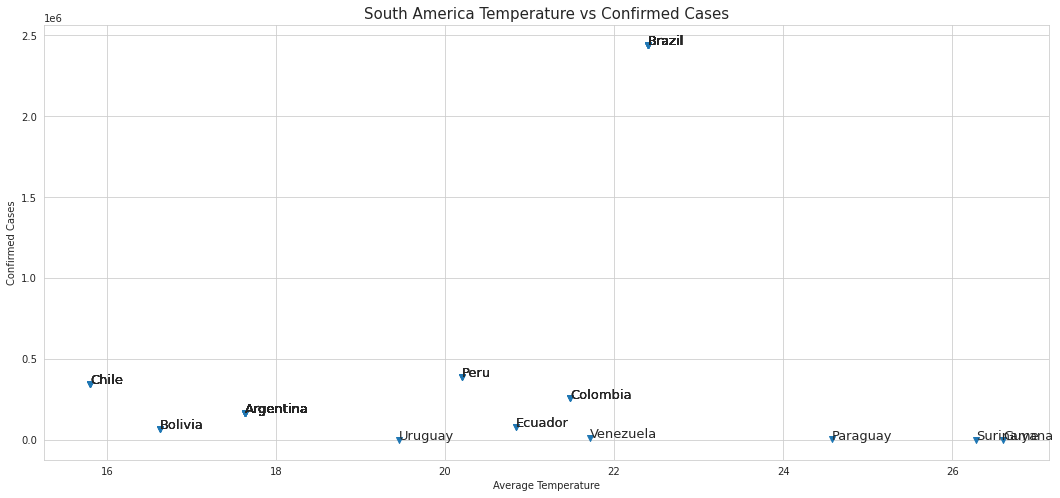

In [43]:
fig, ax = plt.subplots(figsize = (18,8))
ax.scatter(sa_temp['Avg_temp'], sa_temp['Confirmed'], marker='v' )
plt.xlabel('Average Temperature')
plt.ylabel('Confirmed Cases')
plt.title('South America Temperature vs Confirmed Cases', fontsize=15)
for i, txt in zip(sa_temp.index,sa_temp.Country):
    ax.annotate(txt, (sa_temp['Avg_temp'][i], sa_temp['Confirmed'][i]),fontsize=13)

You can see among the five scatter plot, most of countries have the lowest confirmed cases as temperatures get higher.

In [44]:
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected = True)
import plotly.graph_objs as go

## Spatial Visualization

In [45]:
trace2 = [go.Choropleth(
            colorscale = 'Blues',
            locationmode = 'country names',
            locations = full['Country'],
            text = full['Country'],
            z = full['Avg_temp'],colorbar= dict(title='Temperature')
)]

layout = go.Layout(title = 'Country vs Temperature')

fig = go.Figure(data = trace2, layout = layout)
py.iplot(fig)


trace = [go.Choropleth(
            colorscale = 'Blues',
            locationmode = 'country names',
            locations = full['Country'],
            text = full['Country'],
            z = full['Confirmed'],colorbar = dict(title='Confirmed Cases')
)]

layout = go.Layout(title = 'Country vs Confirmed')

fig = go.Figure(data = trace, layout = layout)
py.iplot(fig)

## Social Distancing for Russian Federation and USA

In [46]:
russia = complete[complete['Country/Region'] == 'Russia']
russia.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
185,NaN,Russia,61.52401,105.318756,2020-01-22,0,0,0,0,Europe
446,NaN,Russia,61.52401,105.318756,2020-01-23,0,0,0,0,Europe
707,NaN,Russia,61.52401,105.318756,2020-01-24,0,0,0,0,Europe
968,NaN,Russia,61.52401,105.318756,2020-01-25,0,0,0,0,Europe
1229,NaN,Russia,61.52401,105.318756,2020-01-26,0,0,0,0,Europe


In [47]:
world_temp_2020[world_temp_2020['Country'] == 'russia']

,Country,Jan,Feb,Mar,Apr,May,Avg_temp,Continent


In [82]:
# plot daily cases
colors = ['#FFA500']*85
colors[-5] = 'crimson'
fig = px.bar(russia, 
             x="Date", y="Confirmed", 
             title='<b>New Confirm Cases Per Day In Russia</b>', 
             orientation='v', 
             width=700, height=600)
fig.update_traces(marker_color=colors, opacity=0.8)

fig.add_annotation( # add a text callout with arrow
    text="Social Distancing", x='2020-04-10', y=russia.Confirmed.max(), arrowhead=1, showarrow=True
)

fig.add_annotation( # add a text callout with arrow
    text="Extended Social Distancing", x='2020-04-29', y=russia.Confirmed.max()-1000, arrowhead=1, showarrow=True
)
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0='2020-04-10',
            y0=0,
            x1='2020-04-10',
            y1=russia.Confirmed.max(),
            line=dict(
                color="RoyalBlue",
                width=1,
                dash="dashdot"
            )))

fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0='2020-04-29',
            y0=0,
            x1='2020-04-29',
            y1=russia.Confirmed.max()-1000,
            line=dict(
                color="RoyalBlue",
                width=1,
                dash="dashdot"
            )))

fig.update_layout(template = 'plotly_white',font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig.show()

Even the Social Distancing applied, the new confirmed cases still increase exponentially. We have to look deeper if want to know social distancing are effective or not

In [49]:
russia_00 = russia[russia['Date'] == '2020-03-27']
russia_0 = russia[russia['Date'] == '2020-04-10']
russia_1 = russia[russia['Date'] == '2020-04-24']
russia_2 = russia[russia['Date'] == '2020-05-7']
russia_3 = russia[russia['Date'] == '2020-05-21']


In [51]:
Confirmed_0 = russia_0.Confirmed.iloc[0] - russia_00.Confirmed.iloc[0]
Confirmed_1 = russia_1.Confirmed.iloc[0] - russia_0.Confirmed.iloc[0]
Confirmed_2 = russia_2.Confirmed.iloc[0] - russia_1.Confirmed.iloc[0]
Confirmed_3 = russia_3.Confirmed.iloc[0] - russia_2.Confirmed.iloc[0]

confirmed = [Confirmed_0,Confirmed_1, Confirmed_2, Confirmed_3]
date = ['27 Mar - 10 Apr','10 Apr - 24 Apr', '24 Apr - 7 Mei', '7 Mei - 21 Mei']
social_distancing = ['Before','Before','After','After']

df = pd.DataFrame()
df['confirmed'] = confirmed
df['date'] = date
df['Social_Distancing'] = social_distancing

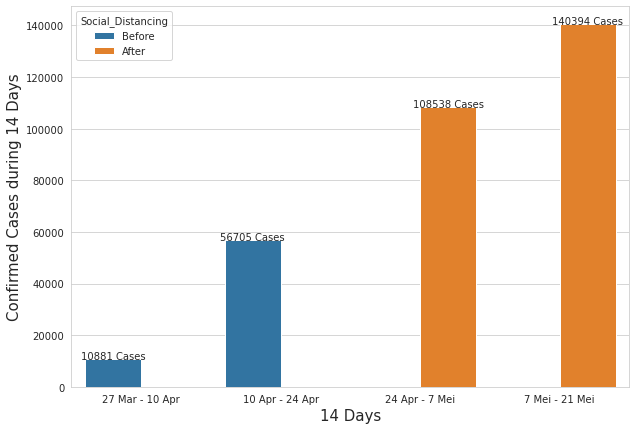

In [52]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'date', y= 'confirmed', hue='Social_Distancing', data=df);

for p in ax.patches:
    
            try:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{} Cases'.format(int(height)),
                    ha="center", fontsize=10)
            except:
                pass
plt.xlabel('14 Days', fontsize= 15)
plt.ylabel('Confirmed Cases during 14 Days', fontsize=15)
plt.show()

In [78]:
france = complete[complete['Country/Region'] == 'France']
france.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
105,French Guiana,France,3.933900,-53.125800,2020-01-22,0,0,0,0,Europe
106,French Polynesia,France,-17.679700,149.406800,2020-01-22,0,0,0,0,Europe
107,Guadeloupe,France,16.265000,-61.551000,2020-01-22,0,0,0,0,Europe
108,Mayotte,France,-12.827500,45.166244,2020-01-22,0,0,0,0,Europe
109,New Caledonia,France,-20.904305,165.618042,2020-01-22,0,0,0,0,Europe


In [79]:
world_temp_2020[world_temp_2020['Country'] == 'France']

,Country,Jan,Feb,Mar,Apr,May,Avg_temp,Continent
198,France,8.4,8.9,11.6,13.8,17.9,10.64,Europe
199,France,4.9,5.6,8.8,11.4,15.1,10.64,Europe


In [83]:
# plot daily cases
colors = ['#FFA500']*85
colors[-5] = 'crimson'
fig = px.bar(france, 
             x="Date", y="Confirmed", 
             title='<b>New Confirm Cases Per Day In France</b>', 
             orientation='v', 
             width=700, height=600)
fig.update_traces(marker_color=colors, opacity=0.8)

fig.add_annotation( # add a text callout with arrow
    text="Social Distancing", x='2020-04-10', y=france.Confirmed.max(), arrowhead=1, showarrow=True
)

fig.add_annotation( # add a text callout with arrow
    text="Extended Social Distancing", x='2020-04-29', y=france.Confirmed.max()-1000, arrowhead=1, showarrow=True
)
fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0='2020-04-10',
            y0=0,
            x1='2020-04-10',
            y1=france.Confirmed.max(),
            line=dict(
                color="RoyalBlue",
                width=1,
                dash="dashdot"
            )))

fig.add_shape(
        # Line Vertical
        dict(
            type="line",
            x0='2020-04-29',
            y0=0,
            x1='2020-04-29',
            y1=france.Confirmed.max()-1000,
            line=dict(
                color="RoyalBlue",
                width=1,
                dash="dashdot"
            )))

fig.update_layout(template = 'plotly_white',font=dict(family="Arial, Balto, Courier New, Droid Sans",color='black'))
fig.show()

In [84]:
france_00 = france[france['Date'] == '2020-03-27']
france_0 = france[france['Date'] == '2020-04-10']
france_1 = france[france['Date'] == '2020-04-24']
france_2 = france[france['Date'] == '2020-05-7']
france_3 = france[france['Date'] == '2020-05-21']

In [85]:
Confirmed_0 = france_0.Confirmed.iloc[0] - france_00.Confirmed.iloc[0]
Confirmed_1 = france_1.Confirmed.iloc[0] - france_0.Confirmed.iloc[0]
Confirmed_2 = france_2.Confirmed.iloc[0] - france_1.Confirmed.iloc[0]
Confirmed_3 = france_3.Confirmed.iloc[0] - france_2.Confirmed.iloc[0]

confirmed = [Confirmed_0,Confirmed_1, Confirmed_2, Confirmed_3]
date = ['27 Mar - 10 Apr','10 Apr - 24 Apr', '24 Apr - 7 Mei', '7 Mei - 21 Mei']
social_distancing = ['Before','Before','After','After']

df = pd.DataFrame()
df['confirmed'] = confirmed
df['date'] = date
df['Social_Distancing'] = social_distancing

In [ ]:
plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'date', y= 'confirmed', hue='Social_Distancing', data=df);

for p in ax.patches:
    
            try:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{} Cases'.format(int(height)),
                    ha="center", fontsize=10)
            except:
                pass
plt.xlabel('14 Days', fontsize= 15)
plt.ylabel('Confirmed Cases during 14 Days', fontsize=15)
plt.show()

You can see, first Social distancing has decreased slightly, but again increased exponentially.

## Effectiveness Social Distancing
I still didn't know this is true or not if I doing this properly. But still I want to try it.

<t> Here I used mitigate.csv, a synthesis data based on China profile, to predict Social Distancing effectiveness in Russia.

In [53]:
gdp = pd.read_csv('/kaggle/input/covid19-different-mitigate-scenarios/GDP_Country.csv')
suppression = pd.read_csv('/kaggle/input/covid19-different-mitigate-scenarios/Suppression.csv')
mitigate = pd.read_csv("/kaggle/input/covid19-different-mitigate-scenarios/Mitigation_Type.csv")

In [56]:
mitigate[mitigate['Country'] == 'Russia']

,Country,R0,Strategy,Social_distance,total_pop,total_infected,total_deaths,total_hospital,total_critical


In [66]:
train.Strategy.unique()

array([1, 2, 0])

In [59]:
merged = pd.concat([train,test])

In [60]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
merged['Strategy'] = merged.Strategy.map({'Enhanced social distancing of elderly': 1,'Social distancing whole population':2, 'Unmitigated':0})

In [61]:
merged.head()

,Country,R0,Strategy,total_pop,total_infected,total_deaths,total_hospital,total_critical
0,Afghanistan,2.4,1,38928341,22235810,42015,342532,55701
1,Afghanistan,2.7,1,38928341,24001697,46456,371943,61587
2,Afghanistan,3.0,1,38928341,25058690,57529,414970,76266
3,Afghanistan,3.3,1,38928341,26214010,60640,434649,80429
4,Afghanistan,2.4,2,38928341,21576989,55929,378738,74147


In [62]:
train = merged.iloc[:len(train),]
test = merged.iloc[len(train):,]

In [63]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

X = train.drop('Country',axis=1)

target = list()
for i in y.str.split('%'):
    target.append(int(i[0]))
    
y = pd.Series(target)

In [64]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 2, random_state = 1, shuffle = True)
np.random.seed(1)
from sklearn.metrics import mean_squared_error

mean = 0
for i,(train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    regressor.fit(X_train,y_train)
    y_pred = regressor.predict(X_test)
    mean += np.sqrt(mean_squared_error(y_train, y_pred))
    
print(mean/2)

28.577342898079323


In [65]:
test.drop('Country', axis=1,inplace=True)
regressor.fit(X,target)
regressor.predict(test)

array([36.])

## References
- [COVID-19 - Temperature, Air Travel & Transmission ](https://www.kaggle.com/sixteenpython/covid-19-temperature-air-travel-transmission)
- [COVID-19 India: Analysis, Visualization, And Comparison](https://www.kaggle.com/vikassingh1996/indiafightscorona-covid-19-comprehensive-study)